In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

2025-05-01 18:19:58.010331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746123598.216603      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746123598.274827      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)


In [3]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [4]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [5]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [6]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [7]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})


In [8]:
train_df.head()


,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [9]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [10]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [11]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [12]:
train_df.duplicated().sum()

0

In [13]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [14]:
val_df.duplicated().sum()

0

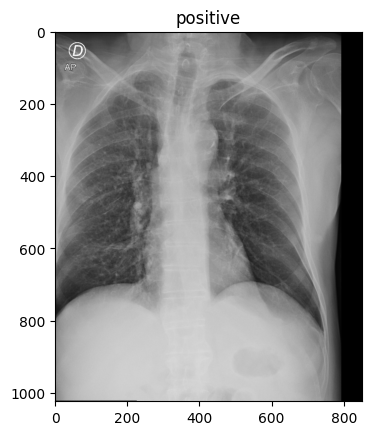

(1024, 851, 3)

In [15]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_df, df_test = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

In [18]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
train_df.diagnosis.value_counts()

diagnosis
positive    45759
negative    45759
Name: count, dtype: int64

In [20]:
df_test.diagnosis.value_counts()

diagnosis
positive    11440
negative     2133
Name: count, dtype: int64

In [21]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0


In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 91518 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_gen, epochs=5, validation_data=val_gen)


I0000 00:00:1746123874.867407      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746123892.468479     103 service.cc:148] XLA service 0x7cfd78001c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746123892.469351     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746123893.095096     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2860 ━━━━━━━━━━━━━━━━━━━━ 4:28 94ms/step - accuracy: 0.4609 - loss: 0.9008   

I0000 00:00:1746123901.957003     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2860/2860 ━━━━━━━━━━━━━━━━━━━━ 3034s 1s/step - accuracy: 0.8069 - loss: 0.4174 - val_accuracy: 0.8770 - val_loss: 0.3019
Epoch 2/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2630s 918ms/step - accuracy: 0.8870 - loss: 0.2836 - val_accuracy: 0.9127 - val_loss: 0.2319
Epoch 3/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2349s 819ms/step - accuracy: 0.9023 - loss: 0.2476 - val_accuracy: 0.9055 - val_loss: 0.2524
Epoch 4/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2328s 812ms/step - accuracy: 0.9080 - loss: 0.2302 - val_accuracy: 0.8971 - val_loss: 0.2624
Epoch 5/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2492s 869ms/step - accuracy: 0.9181 - loss: 0.2112 - val_accuracy: 0.9084 - val_loss: 0.2350


In [32]:
test_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=df_test, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 13573 validated image filenames belonging to 2 classes.


In [33]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
y_test = test_gen.classes
y_proba_test = model.predict(test_gen, verbose=1)
y_pred_test = (y_proba_test > 0.5).astype(int)
print("\nVGG19 Test Results:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test,y_pred_test))
print("AUC Score:", roc_auc_score(y_test,y_proba_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 320s 752ms/step

VGG19 Test Results:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2133
           1       0.97      0.98      0.98     11440

    accuracy                           0.96     13573
   macro avg       0.94      0.91      0.92     13573
weighted avg       0.96      0.96      0.96     13573

Accuracy: 0.9605835113828926
AUC Score: 0.9728110175103846


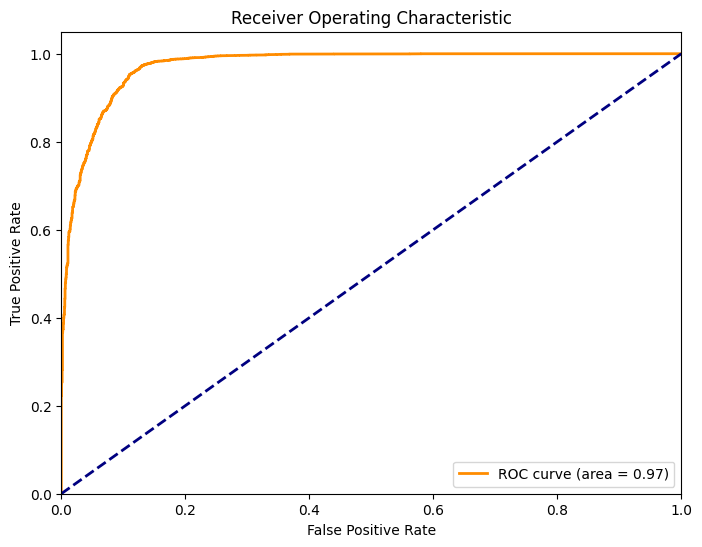

In [54]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


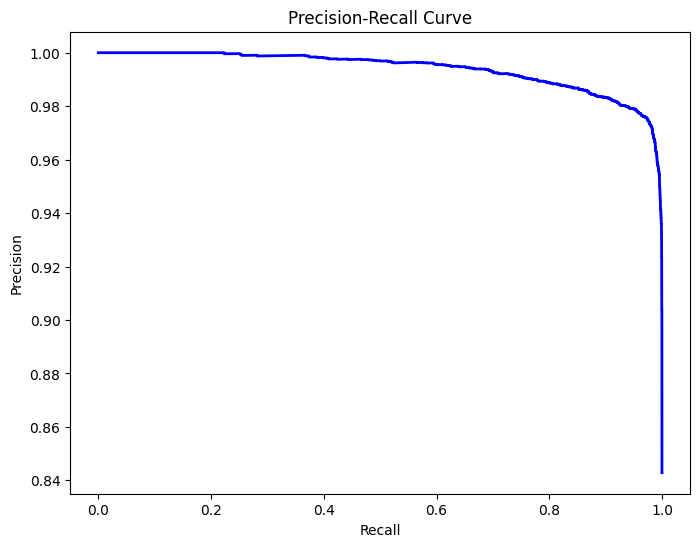

In [55]:
from sklearn.metrics import precision_recall_curve
# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


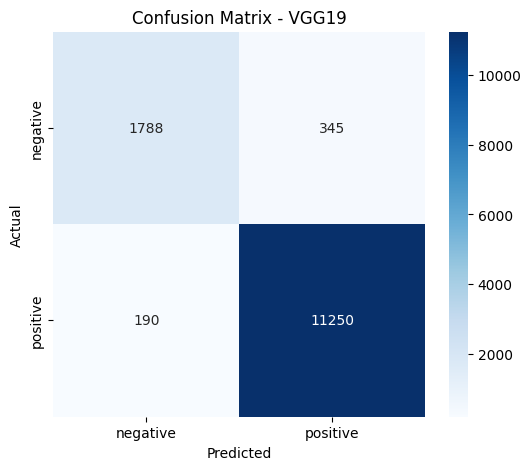

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
class_labels = ['negative', 'positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - VGG19')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

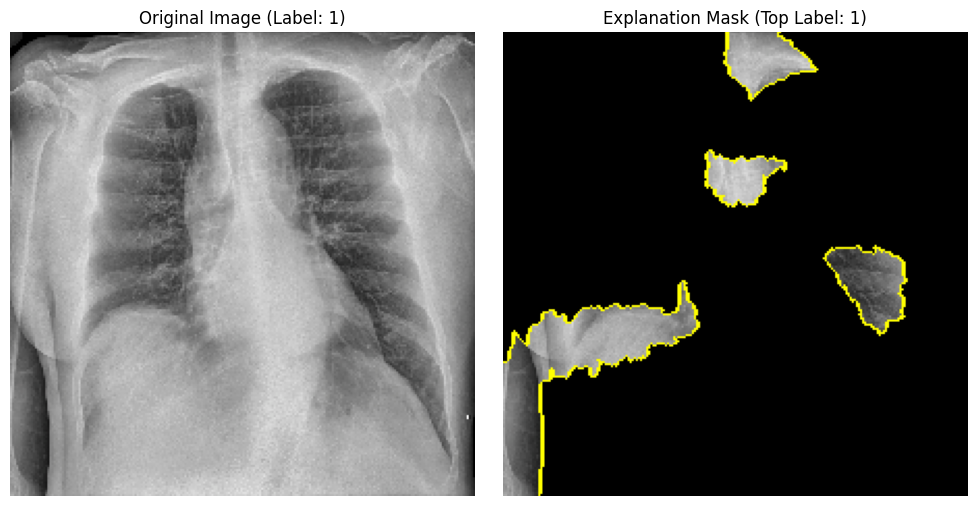

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

def custom_preprocess(img):
    return img / 255.0  

def predict_fn(images):
    processed_images = np.array([custom_preprocess(img) for img in images])
    preds = cnn_model.predict(processed_images)  
    return np.concatenate([1 - preds, preds], axis=1)  
idx = 0
img_batch, label_batch = test_gen[idx]
img = img_batch[0]
true_label = int(label_batch[0])
if img.shape[-1] == 1:
    img = np.repeat(img, 3, axis=-1)
img_for_lime = (img * 255).astype(np.uint8)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_for_lime,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original Image (Label: {true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation Mask (Top Label: {explanation.top_labels[0]})")
plt.axis('off')

plt.tight_layout()
plt.show()


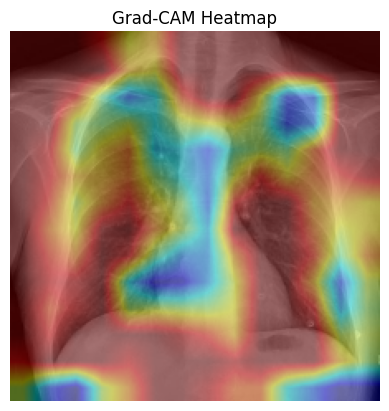

In [116]:
# Grad-CAM setup
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay
def load_and_preprocess_image(img_path):
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_clahe = custom_preprocess(img_resized)
    return np.expand_dims(img_clahe, axis=0)

img_path = "/kaggle/input/covidx-cxr2/train/000001-3.jpg"
img_array = load_and_preprocess_image(img_path)

heatmap = make_gradcam_heatmap(img_array, base_model, "block5_conv3")
overlay = overlay_heatmap(heatmap, (img_array[0] * 255).astype(np.uint8))

plt.imshow(overlay)
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()